In [11]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy

from z3 import *
import grilops
import grilops.regions

In [12]:
# Back to the first problem. Redoing withh Z3
url='https://www.janestreet.com/puzzles/its-symmetric/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
print("Puzzle")
print("~~~~~~")
print(" ".join(y[8:10]))

Puzzle
~~~~~~
(A few examples: In a 1-by-N region, all cells could be labeled 0, since a reflection across the longer mid-line takes every cell to itself. In the “S”-shaped Tetris piece, the cells could be labeled 3, 1, 1, 3.) The answer to this puzzle is the


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/03/20180301_symmetric.png" width="350" >


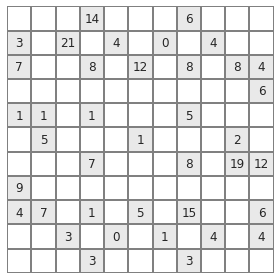

In [13]:
givens = np.array([[-1, -1, -1, 14, -1, -1, -1,  6, -1, -1, -1],
                   [ 3, -1, 21, -1,  4, -1,  0, -1,  4, -1, -1],
                   [ 7, -1, -1,  8, -1, 12, -1,  8, -1,  8,  4],
                   [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  6],
                   [ 1,  1, -1,  1, -1, -1, -1,  5, -1, -1, -1],
                   [-1,  5, -1, -1, -1,  1, -1, -1, -1,  2, -1],
                   [-1, -1, -1,  7, -1, -1, -1,  8, -1, 19, 12],
                   [ 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                   [ 4,  7, -1,  1, -1,  5, -1, 15, -1, -1,  6],
                   [-1, -1,  3, -1,  0, -1,  1, -1,  4, -1,  4],
                   [-1, -1, -1,  3, -1, -1, -1,  3, -1, -1, -1]])

fig,ax = plt.subplots(1,1,figsize=(4,4))
x = np.array((givens).astype('int').astype('str'))
x[x=="-1"] =""
ax =sns.heatmap(givens!=-1,annot=x,cbar=False,center=3,cmap="Greys",fmt="",linewidths=1,linecolor="grey",annot_kws={"size":12})
ax.axis("off")
plt.tight_layout()

In [78]:
givens=np.array([[-1,-1, 4, 9],
                 [-1,-1, 0,-1],
                 [-1, 2,-1,-1],
                 [ 3, 1,-1,-1]])

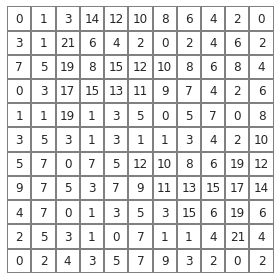

In [83]:
givens = np.array([[ 0,  1,  3, 14, 12, 10,  8,  6,  4,  2,  0],
                   [ 3,  1, 21,  6,  4,  2,  0,  2,  4,  6,  2],
                   [ 7,  5, 19,  8, 15, 12, 10,  8,  6,  8,  4],
                   [ 0,  3, 17, 15, 13, 11,  9,  7,  4,  2,  6],
                   [ 1,  1, 19,  1,  3,  5,  0,  5,  7,  0,  8],
                   [ 3,  5,  3,  1,  3,  1,  1,  3,  4,  2, 10],
                   [ 5,  7,  0,  7,  5, 12, 10,  8,  6, 19, 12],
                   [ 9,  7,  5,  3,  7,  9, 11, 13, 15, 17, 14],
                   [ 4,  7,  0,  1,  3,  5,  3, 15,  6, 19,  6],
                   [ 2,  5,  3,  1,  0,  7,  1,  1,  4, 21,  4],
                   [ 0,  2,  4,  3,  5,  7,  9,  3,  2,  0,  2]])

fig,ax = plt.subplots(1,1,figsize=(4,4))
x = np.array((givens).astype('int').astype('str'))
x[x=="-1"] =""
ax =sns.heatmap(givens!=-1,annot=x,cbar=False,center=3,cmap="Greys",fmt="",linewidths=1,linecolor="grey",annot_kws={"size":12})
ax.axis("off")
plt.tight_layout()

Solved in 0.7699394226074219 seconds


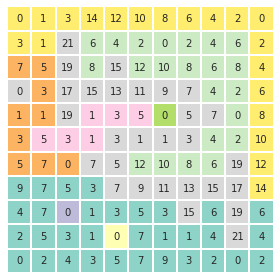

In [84]:
N= givens.shape[0]


def neigbours(grid, i, j):     
    l = []
    (rows,cols) = grid.shape
    if i-1 >= 0:
            l.append((i-1,j))
    if i+1 < rows:
            l.append((i+1,j))
    if j-1 >= 0:
            l.append((i,j-1))
    if j+1 < cols:
            l.append((i,j+1))
    return l

s = Solver()

X = [[Int("x_%s_%s" % (i+1, j+1)) for j in range(N)] for i in range(N)]
size = [[Int("s%d%d" % (i,j)) for j in range (N) ] for i in range (N) ]

# Variables for the root of each tree
root = [[Int("r%d%d" % (i,j)) for j in range (N) ] for i in range (N) ]

edge = {}
for i in range(N):
    for j in range(N):  
        for (k,l) in neigbours(givens,i,j) :
            edge[(i,j,k,l)] = Int("e%d%d%d%d" % (i,j,k,l))
            s += Or(edge[(i,j,k,l)] ==0,edge[(i,j,k,l)]==1) 

s += [X[i][j] >=0 for j in range(N) for i in range(N)]     

s += [X[i][j] == int(givens[i,j]) for j in range(N) for i in range(N) if givens[i,j] != -1]  

# Define a variable to determine if there is an edge between 2 cells
for i in range(N):
    for j in range(N):  
        for (k,l) in neigbours(givens,i,j):
            s += (edge[(i,j,k,l)] + edge[(k,l,i,j)]) <= 1
    
# Make edges one way to form a tree
for i in range(N):
    for j in range(N):  
        s += Sum([edge[(k,l,i,j)] for (k,l) in neigbours(givens,i,j) ]) <=1  
        
# Calculate size of cell as 1 + the cells it feeds into
for i in range(N):
    for j in range(N):   
        s +=  size[i][j] == Sum([If(edge[(i,j,k,l)]==1,size[k][l],0) for (k,l) in neigbours(givens,i,j)])+1

# put the root cell number in the root
for i in range(N):
    for j in range(N):  
        s+= Implies(Sum([edge[(k,l,i,j)] for (k,l) in neigbours(givens,i,j)]) == 0 ,root[i][j]==i*N+j)              

# root size must be number +1
for i in range(N):
    for j in range(N):  
        s+= Implies(Sum([edge[(k,l,i,j)] for (k,l) in neigbours(givens,i,j)]) == 0 ,size[i][j]>X[i][j])      
        
# shared edges have the same root and are either 1:1 or x:x+2
for i in range(N):
    for j in range(N):  
        for (k,l) in neigbours(givens,i,j):
            s+= Implies(edge[(k,l,i,j)]  == 1 ,root[i][j] == root[k][l])
            s+= Implies(edge[(k,l,i,j)]  == 1 ,Or(X[i][j]+2 == X[k][l],X[i][j] == X[k][l]+2,And(X[i][j] == 1, X[k][l]== 1)))

# each number apart from 0 appears twice
for i in range(N):
    for j in range(N):              
        s+=Implies(X[i][j] != 0,
                   PbGe(
                       [(And(root[i][j]==root[k][l],X[i][j]==X[k][l]),1) for k in range(N) for l in range(N)]
                       ,2))
        
start = time.time()
if s.check() == sat:
    m = s.model()
    r = np.array([ [ m.evaluate(X[i][j]).as_long() for j in range(N) ] for i in range(N) ])
    roots = np.array([ [ m.evaluate(root[i][j]).as_long() for j in range(N) ] for i in range(N) ])
    print("Solved in {} seconds".format(time.time()-start))
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    ax = sns.heatmap(roots,annot=r,cbar=False,cmap="Set3_r",fmt="",linewidths=1)
    ax.axis("off")
    plt.tight_layout()

else:
    print("Failed in {} seconds".format(time.time()-start))


In [46]:
url='https://www.janestreet.com/puzzles/solutions/march-2018-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print("Solution")
print("~~~~~~~~")
print(" ".join(x[7:10]))

Solution
~~~~~~~~
The completed grid is presented here, and the sum of the cubes of the areas of the different regions is 33,679 .  Congrats to everyone who solved this month’s puzzle!


### Solution
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/04/Mar18_solution.png" width="400">


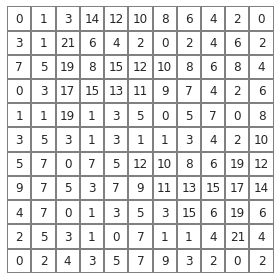

In [27]:
givens = np.array([[ 0,  1,  3, 14, 12, 10,  8,  6,  4,  2,  0],
                   [ 3,  1, 21,  6,  4,  2,  0,  2,  4,  6,  2],
                   [ 7,  5, 19,  8, 15, 12, 10,  8,  6,  8,  4],
                   [ 0,  3, 17, 15, 13, 11,  9,  7,  4,  2,  6],
                   [ 1,  1, 19,  1,  3,  5,  0,  5,  7,  0,  8],
                   [ 3,  5,  3,  1,  3,  1,  1,  3,  4,  2, 10],
                   [ 5,  7,  0,  7,  5, 12, 10,  8,  6, 19, 12],
                   [ 9,  7,  5,  3,  7,  9, 11, 13, 15, 17, 14],
                   [ 4,  7,  0,  1,  3,  5,  3, 15,  6, 19,  6],
                   [ 2,  5,  3,  1,  0,  7,  1,  1,  4, 21,  4],
                   [ 0,  2,  4,  3,  5,  7,  9,  3,  2,  0,  2]])

fig,ax = plt.subplots(1,1,figsize=(4,4))
x = np.array((givens).astype('int').astype('str'))
x[x=="-1"] =""
ax =sns.heatmap(givens!=-1,annot=x,cbar=False,center=3,cmap="Greys",fmt="",linewidths=1,linecolor="grey",annot_kws={"size":12})
ax.axis("off")
plt.tight_layout()

In [26]:
givens

array([[ 0,  1,  3, 14, 12, 10,  8,  6,  4,  2,  0],
       [ 3,  1, 21,  6,  4,  2,  0,  2,  4,  6,  2],
       [ 7,  5, 19,  8, 15, 12, 10,  8,  6,  8,  4],
       [ 0,  3, 17, 15, 13, 11,  9,  7,  4,  2,  6],
       [ 1,  1, 19,  1,  3,  5,  0,  5,  7,  0,  8],
       [ 3,  5,  3,  1,  3,  1,  1,  3,  4,  2, 10],
       [ 5,  7,  0,  7,  5, 12, 10,  8,  6, 19, 12],
       [ 9,  7,  5,  3,  7,  9, 11, 13, 15, 17, 14],
       [ 4,  7,  0,  1,  3,  5,  3, 15,  6, 19,  6],
       [ 2,  5,  3,  1,  0,  7,  1,  1,  4, 21,  4],
       [ 0,  2,  4,  3,  5,  7,  9,  3,  2,  0,  2]])

array([[  0,  11,  22,  33,  44,  55,  66,  77,  88,  99, 110],
       [  1,  12,  23,  34,  45,  56,  67,  78,  89, 100, 111],
       [  2,  13,  24,  35,  46,  57,  68,  79,  90, 101, 112],
       [  3,  14,  25,  36,  47,  58,  69,  80,  91, 102, 113],
       [  4,  15,  26,  37,  48,  59,  70,  81,  92, 103, 114],
       [  5,  16,  27,  38,  49,  60,  71,  82,  93, 104, 115],
       [  6,  17,  28,  39,  50,  61,  72,  83,  94, 105, 116],
       [  7,  18,  29,  40,  51,  62,  73,  84,  95, 106, 117],
       [  8,  19,  30,  41,  52,  63,  74,  85,  96, 107, 118],
       [  9,  20,  31,  42,  53,  64,  75,  86,  97, 108, 119],
       [ 10,  21,  32,  43,  54,  65,  76,  87,  98, 109, 120]])